# Univariate LSTM Time Series Prediction

In [134]:
# Plotting
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 15, 6

# ignore warnings in this demo notebook
import warnings; warnings.simplefilter('ignore')

from datetime import datetime
import pandas as pd
import numpy as np

# Normalization
from sklearn.preprocessing import MinMaxScaler

# Deep-learing
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras import backend as K


from python_code.data_preparation import create_tensors
from python_code.keras_utils import predict_with_uncertainty

## Data Description

A detailed data description can be found on Kaggle: [Kaggle: Smart Meters in London](https://www.kaggle.com/jeanmidev/smart-meters-in-london).

### Parameters

#### Data Parameters

You may have to modify the data preparation file (*00_load_smart_meter_data.R*) when applying this code to your own data. 

- Number of series: 4961
- Date range: 2013-10-30 00:00:00 CET to 2014-02-27 23:00:00 CET (121 days)
- End test range: 2014-01-27 23:00:00 (90 days)
- One days ahead prediction

In [11]:
data_path = 'prepared_data/london_smart_meter/'
file = 'smart_meters_london_cleaned_same_start.csv'
h_params = {'n_in': 24, 'n_out': 24, 'step_foreward': 24, 'column_value': 'energy'}
date_train =  datetime.strptime('2014-01-27 23:00:00', '%Y-%m-%d %H:%M:%S')

### Load Data

The Kaggle dataset was cleaned and prepared in R (`00_load_smart_meter_data.R`). The smart meter series are saved in the long format. 

In [12]:
df = pd.read_csv(data_path + file,
                 parse_dates={'date' : ['date_time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col=['date'])

`write_csv` from the `readr` package writes date time values in UCT format. Therefore, we have set the correct zone.

In [13]:
df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')
df.head()

,id,energy
date,,
2013-10-30 00:00:00+01:00,MAC000002,0.457
2013-10-30 01:00:00+01:00,MAC000002,0.414
2013-10-30 02:00:00+01:00,MAC000002,0.408
2013-10-30 03:00:00+01:00,MAC000002,0.352
2013-10-30 04:00:00+01:00,MAC000002,0.250


Let us check some characteristics of the series.

In [73]:
uniqueIDs = df['id'].unique()
len(uniqueIDs)

4961

In [15]:
df.groupby('id').count().describe()

,energy
count,4961.0
mean,2904.0
std,0.0
min,2904.0
25%,2904.0
50%,2904.0
75%,2904.0
max,2904.0


In [16]:
2904 / 24

121.0

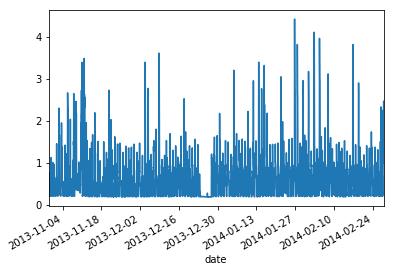

In [63]:
df[df['id'] == 'MAC000002']['energy'].plot()

Now, splite train and test.

In [19]:
df_train = df[df.index <= date_train]
df_test = df[df.index > date_train]

## Prepare Data for LSTM

Let us start with a single series. In the next steps we have to generate the 3 dimensional arrays ([samples, n_in, n_features]) that we need for the LSTM. But before we do this, we have to normalize data. 

In [20]:
df_train = df_train[df_train['id'] == 'MAC000002']
df_test = df_test[df_test['id'] == 'MAC000002']

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
# train the scaler on the training data
scaler.fit(df_train[[h_params['column_value']]])
df_train[[h_params['column_value']]] = scaler.transform(df_train[[h_params['column_value']]])
df_test[[h_params['column_value']]] = scaler.transform(df_test[[h_params['column_value']]])

In [23]:
df_train[[h_params['column_value']]].describe()

,energy
count,2160.000000
mean,0.090101
std,0.118516
min,0.000000
25%,0.005903
50%,0.052302
75%,0.140024
max,1.000000


In [31]:
train_X, train_y = create_tensors(df_train.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])

In [34]:
train_X.shape

(89, 24, 1)

### Define & Train LSTM Network

Let us try a simple 3 layer LSTM network.  

In [125]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(h_params['n_out']))
model.compile(loss='mean_squared_error', optimizer = keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))

# fit network
history = model.fit(train_X, train_y, epochs=25, batch_size=1, validation_split = .1, verbose=2, shuffle=True)

Train on 80 samples, validate on 9 samples
Epoch 1/25
 - 8s - loss: 0.0107 - val_loss: 0.0163
Epoch 2/25
 - 6s - loss: 0.0090 - val_loss: 0.0149
Epoch 3/25
 - 6s - loss: 0.0088 - val_loss: 0.0138
Epoch 4/25
 - 6s - loss: 0.0088 - val_loss: 0.0139
Epoch 5/25
 - 6s - loss: 0.0086 - val_loss: 0.0125
Epoch 6/25
 - 6s - loss: 0.0086 - val_loss: 0.0146
Epoch 7/25
 - 6s - loss: 0.0084 - val_loss: 0.0144
Epoch 8/25
 - 6s - loss: 0.0086 - val_loss: 0.0138
Epoch 9/25
 - 6s - loss: 0.0084 - val_loss: 0.0122
Epoch 10/25
 - 6s - loss: 0.0084 - val_loss: 0.0123
Epoch 11/25
 - 6s - loss: 0.0082 - val_loss: 0.0135
Epoch 12/25
 - 6s - loss: 0.0082 - val_loss: 0.0133
Epoch 13/25
 - 6s - loss: 0.0083 - val_loss: 0.0132
Epoch 14/25
 - 7s - loss: 0.0083 - val_loss: 0.0143
Epoch 15/25
 - 6s - loss: 0.0084 - val_loss: 0.0127
Epoch 16/25
 - 6s - loss: 0.0083 - val_loss: 0.0119
Epoch 17/25
 - 6s - loss: 0.0083 - val_loss: 0.0131
Epoch 18/25
 - 6s - loss: 0.0078 - val_loss: 0.0114
Epoch 19/25
 - 6s - loss: 0.00

Summarise the training and validation loss

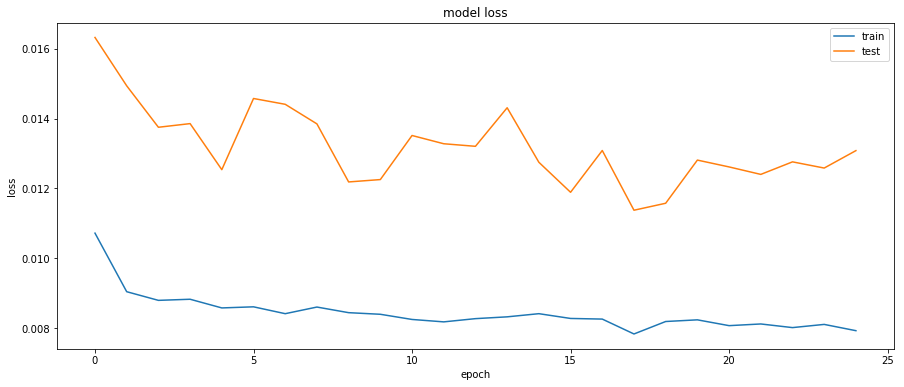

In [126]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Perform prediction

In [127]:
test_X, test_y = create_tensors(df_test.drop('id', axis = 1), h_params['column_value'], h_params['n_in'], h_params['n_out'], h_params['step_foreward'])
prediction = model.predict(test_X)

In [128]:
yHat = scaler.inverse_transform(prediction).reshape(prediction.shape[0] * prediction.shape[1])
y = scaler.inverse_transform(test_y).reshape(prediction.shape[0] * prediction.shape[1])

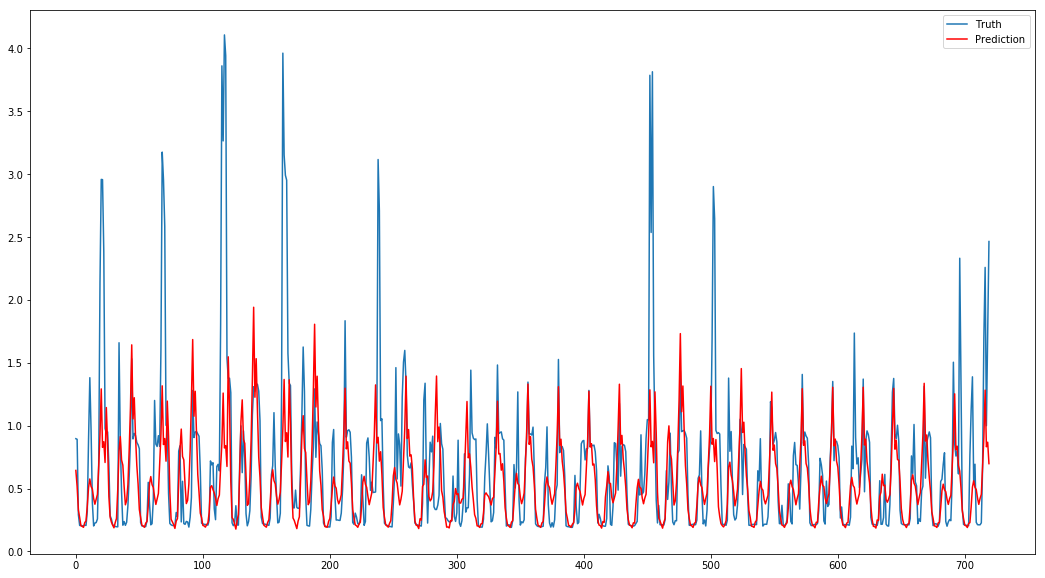

In [131]:
plt.figure(figsize=(18,10))
plt.plot(y)
plt.plot(yHat, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.show()

In [132]:
mape = np.mean(np.abs((yHat - y) / y )) * 100
smape = np.mean(np.abs((yHat - y) / (np.abs(y) + np.abs(yHat)) )) * 100
print("MAPE: %.2f SMAPE: %.2f" % (mape, smape))

MAPE: 40.01 SMAPE: 18.19


This can be done better. But let us next try to calculate confidence bands.

## Confidence Bands

In [142]:
def predict_with_uncertainty(model, test_X, n_iter=100):
    f = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    all_pred = np.zeros((n_iter,) + (1, 24,))
    for iter in range(n_iter):
        all_pred[iter] = f([test_X, 1])
    avg_pred = all_pred.mean(axis=0)
    std = np.std(all_pred, axis=0)
    return all_pred, avg_pred, std

ValueError: could not broadcast input array from shape (30,24) into shape (24)

In [ ]:
predict_with_uncertainty(model, test_X)